In [1]:
# imports
import os
import math
import dill
from itertools import permutations, combinations

import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from matplotlib import gridspec
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression as linreg

import suite2p as s2p

import TwoPUtils
import STX3KO_analyses as stx



%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
basedir_VR = '/home/mplitt/VR_scratch'
figdir_local = '/mnt/BigDisk/YMazeResults'
figdir_remote = '/STX3_2P_results/YMaze/behavior'

In [3]:
ko_sessions, ctrl_sessions = stx.behavior.model_comparison.get_session_dicts()

4467975.1 ({'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14})


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467975.1 {'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}
4467975.1 {'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}
4467975.1 {'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}
4467975.1 {'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}
4467975.1 {'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}
4467975.1 ({'date': '04_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '04_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 2, 'scan': 10})


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467975.1 {'date': '05_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 3}
4467975.1 ({'date': '06_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 2}, {'date': '06_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5})


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467975.2 {'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467975.2 {'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467975.2 {'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467975.2 {'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}
4467975.2 {'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467975.2 {'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467975.2 ({'date': '04_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}, {'date': '04_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 5})


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467975.2 {'date': '05_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467975.2 ({'date': '06_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 5}, {'date': '06_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8})


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467975.3 {'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467975.3 {'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}
4467975.3 {'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7}
4467975.3 {'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7}
4467975.3 {'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467975.3 {'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6}
4467975.3 ({'date': '04_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '04_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 6})


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467975.3 {'date': '05_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 3}
4467975.3 ({'date': '06_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 4}, {'date': '06_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8})
4467975.4 {'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467975.4 {'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}
4467975.4 {'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}
4467975.4 {'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}
4467975.4 {'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}
4467975.4 {'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}
4467975.4 ({'date': '04_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}, {'date': '04_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 5})


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467975.4 {'date': '05_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 3}
4467975.4 ({'date': '06_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 4}, {'date': '06_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8})


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467975.5 {'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467975.5 {'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}
4467975.5 {'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5}
4467975.5 {'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7}
4467975.5 {'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}
4467975.5 {'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5}
4467975.5 ({'date': '04_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}, {'date': '04_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 8})


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467975.5 {'date': '05_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 3}
4467975.5 ({'date': '06_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 5}, {'date': '06_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9})
4467331.1 {'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467331.1 {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467331.1 {'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467331.1 {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467331.1 {'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8}
4467331.1 {'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}
4467331.1 ({'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}, {'date': '05_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 4})


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467331.1 {'date': '06_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 2, 'scan': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467331.1 ({'date': '07_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 3}, {'date': '07_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5})


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467331.2 {'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467331.2 {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467331.2 {'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467331.2 ({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6}, {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 12})


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467331.2 {'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467331.2 {'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467331.2 ({'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}, {'date': '05_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 4})


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467331.2 {'date': '06_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467331.2 ({'date': '07_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 2}, {'date': '07_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4})


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467332.1 {'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467332.1 {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467332.1 {'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467332.1 {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467332.1 {'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}
4467332.1 {'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467332.1 ({'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '05_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 5})


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467332.1 {'date': '06_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467332.1 ({'date': '07_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 2}, {'date': '07_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5})


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467332.2 ({'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 14}, {'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18})


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467332.2 ({'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}, {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 9})


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467332.2 {'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}
4467332.2 {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467332.2 {'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}
4467332.2 {'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}
4467332.2 ({'date': '06_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '06_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 6})


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467332.2 {'date': '06_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 2, 'scan': 2}
4467332.2 ({'date': '07_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 2}, {'date': '07_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6})


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467333.1 {'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467333.1 {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467333.1 {'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467333.1 {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467333.1 {'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467333.1 {'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467333.1 ({'date': '06_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}, {'date': '06_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 5})


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467333.1 {'date': '07_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467333.1 ({'date': '08_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 2}, {'date': '08_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4})


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


In [4]:
lick_varpos_results_familiar = stx.behavior.run_model_comparisons.run_model_comparisons_familiar(ko_sessions,ctrl_sessions, 'lick_varpos')
with open(os.path.join(figdir_local,'lick_varpos_results_familiar.pkl'),'wb') as file:
    dill.dump(lick_varpos_results_familiar,file)

log likelihood [-716.55197317 -720.0111723  -722.77767772 -724.52132503 -720.81453821
 -722.0952586  -723.27396548 -724.38561577]
perm 0
perm 50
perm 100
perm 150
perm 200
Day 0
M0, true log likelihood -716.551973, highest perm log likelihood -716.551973, 'p' value 1.000000
M1, true log likelihood -720.011172, highest perm log likelihood -707.428864, 'p' value 0.216000
M2, true log likelihood -722.777678, highest perm log likelihood -702.855598, 'p' value 0.368000
M3, true log likelihood -724.521325, highest perm log likelihood -703.126354, 'p' value 0.448000
M4, true log likelihood -720.814538, highest perm log likelihood -705.672744, 'p' value 0.248000
M5, true log likelihood -722.095259, highest perm log likelihood -706.186699, 'p' value 0.272000
M6, true log likelihood -723.273965, highest perm log likelihood -704.317572, 'p' value 0.352000
M7, true log likelihood -724.385616, highest perm log likelihood -704.580007, 'p' value 0.440000


/home/mplitt/repos/STX3KO_analyses/STX3KO_analyses/behavior/models.py:83: RuntimeWarning: overflow encountered in exp
  return (a0 * x[1, :] + a1 * (1 - x[1, :])) * np.exp(-1 * (b0 * x[1, :] + b1 * (1 - x[1, :])) * x[0, :]) + c


log likelihood [-663.1886512  -657.94421573 -659.96109921 -655.99355086 -662.86492635
 -659.20986852 -660.94206662 -660.35789427]
perm 0


/home/mplitt/repos/STX3KO_analyses/STX3KO_analyses/behavior/models.py:134: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-1 * (b0 * x[1, :] + b1 * (1 - x[1, :])) * x[0, :]) + c0 * x[1, :] + c1 * (1 - x[1, :])


perm 50
perm 100
perm 150
perm 200
Day 1
M0, true log likelihood -663.188651, highest perm log likelihood -663.188651, 'p' value 1.000000
M1, true log likelihood -657.944216, highest perm log likelihood -654.966531, 'p' value 0.040000
M2, true log likelihood -659.961099, highest perm log likelihood -650.935805, 'p' value 0.144000
M3, true log likelihood -655.993551, highest perm log likelihood -650.505510, 'p' value 0.032000
M4, true log likelihood -662.864926, highest perm log likelihood -647.976159, 'p' value 0.240000
M5, true log likelihood -659.209869, highest perm log likelihood -651.638381, 'p' value 0.104000
M6, true log likelihood -660.942067, highest perm log likelihood -645.650498, 'p' value 0.216000
M7, true log likelihood -660.357894, highest perm log likelihood -649.991624, 'p' value 0.160000
log likelihood [-518.86582076 -531.11448936 -539.27840601 -544.59714501 -536.57313497
 -537.32544904 -532.20724081 -541.63185734]
perm 0
perm 50
perm 100
perm 150
perm 200
Day 2
M0, t

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/BigDisk/YMazeResutls/lick_varpos_results_familiar.pkl'

In [6]:
with open(os.path.join(figdir_local,'lick_varpos_results_familiar.pkl'),'wb') as file:
    dill.dump(lick_varpos_results_familiar,file)

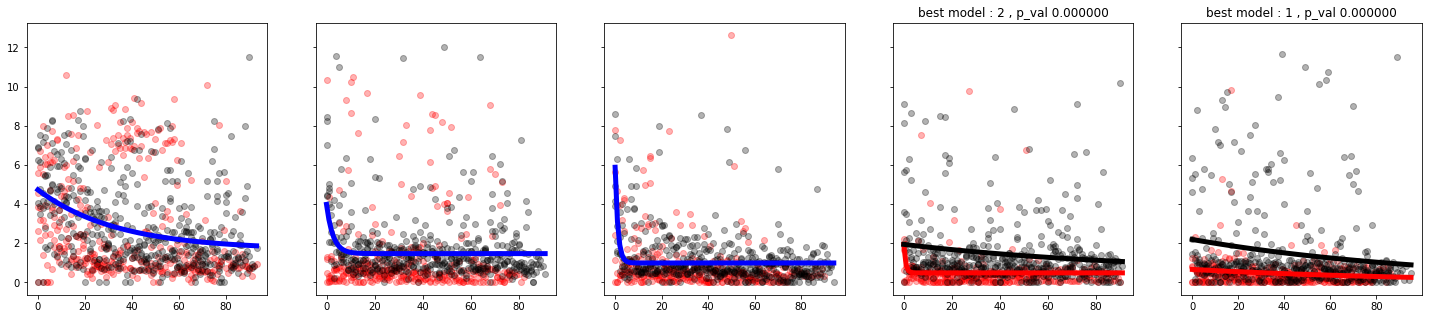

In [7]:
fig,ax = stx.behavior.run_model_comparisons.plot_famnov_results(ko_sessions, ctrl_sessions,lick_varpos_results_familiar,'lick_varpos')
fig.savefig(os.path.join(figdir_local,'lick_varpos_results_familiar.png'))
fig.savefig(os.path.join(figdir_local,'lick_varpos_results_familiar.pdf'))

log likelihood [-3.30133354 -6.30507076  0.52383736 -3.6153329   1.75226049 -1.44513124
 -4.7502174  -3.4710103 ]
perm 0
perm 50
perm 100
perm 150
perm 200
Day 0
M0, true log likelihood -3.301334, highest perm log likelihood -3.301333, 'p' value 1.000000
M1, true log likelihood -6.305071, highest perm log likelihood 7.964639, 'p' value 0.512000
M2, true log likelihood 0.523837, highest perm log likelihood 19.145338, 'p' value 0.176000
M3, true log likelihood -3.615333, highest perm log likelihood 16.542520, 'p' value 0.272000
M4, true log likelihood 1.752260, highest perm log likelihood 19.045453, 'p' value 0.088000
M5, true log likelihood -1.445131, highest perm log likelihood 14.754995, 'p' value 0.200000
M6, true log likelihood -4.750217, highest perm log likelihood 18.309265, 'p' value 0.296000
M7, true log likelihood -3.471010, highest perm log likelihood 17.026617, 'p' value 0.256000
log likelihood [69.98584774 87.37243186 73.01747531 85.46213153 75.9744677  86.87662424
 74.45467

/home/mplitt/repos/STX3KO_analyses/STX3KO_analyses/behavior/models.py:65: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-1 * (b0 * x[1, :] + b1 * (1 - x[1, :])) * x[0, :]) + c
/home/mplitt/repos/STX3KO_analyses/STX3KO_analyses/behavior/models.py:83: RuntimeWarning: overflow encountered in exp
  return (a0 * x[1, :] + a1 * (1 - x[1, :])) * np.exp(-1 * (b0 * x[1, :] + b1 * (1 - x[1, :])) * x[0, :]) + c
/home/mplitt/repos/STX3KO_analyses/STX3KO_analyses/behavior/models.py:83: RuntimeWarning: overflow encountered in multiply
  return (a0 * x[1, :] + a1 * (1 - x[1, :])) * np.exp(-1 * (b0 * x[1, :] + b1 * (1 - x[1, :])) * x[0, :]) + c


perm 100


/home/mplitt/repos/STX3KO_analyses/STX3KO_analyses/behavior/models.py:153: RuntimeWarning: overflow encountered in exp
  return (a0 * x[1, :] + a1 * (1 - x[1, :])) * np.exp(-1 * (b0 * x[1, :] + b1 * (1 - x[1, :])) * x[0, :]) + \
/home/mplitt/repos/STX3KO_analyses/STX3KO_analyses/behavior/models.py:153: RuntimeWarning: overflow encountered in multiply
  return (a0 * x[1, :] + a1 * (1 - x[1, :])) * np.exp(-1 * (b0 * x[1, :] + b1 * (1 - x[1, :])) * x[0, :]) + \


perm 150
perm 200
Day 4
M0, true log likelihood 125.980336, highest perm log likelihood 125.980336, 'p' value 1.000000
M1, true log likelihood 134.244924, highest perm log likelihood 138.338799, 'p' value 0.040000
M2, true log likelihood 133.695750, highest perm log likelihood 138.155330, 'p' value 0.032000
M3, true log likelihood 128.237189, highest perm log likelihood 135.759287, 'p' value 0.080000
M4, true log likelihood 128.755145, highest perm log likelihood 132.117998, 'p' value 0.064000
M5, true log likelihood 133.980392, highest perm log likelihood 135.614562, 'p' value 0.032000
M6, true log likelihood 134.374631, highest perm log likelihood 137.897531, 'p' value 0.024000
M7, true log likelihood 134.295452, highest perm log likelihood 135.122819, 'p' value 0.016000


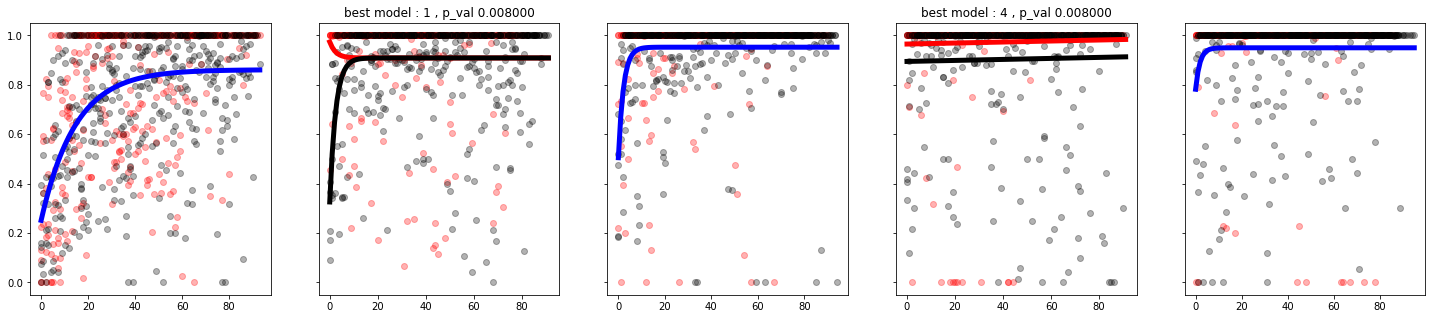

In [4]:
lick_acc_results_familiar = stx.behavior.run_model_comparisons.run_model_comparisons_familiar(ko_sessions,ctrl_sessions, 'lick_acc')
with open(os.path.join(figdir_local,'lick_acc_results_familiar.pkl'),'wb') as file:
    dill.dump(lick_acc_results_familiar,file)
    
fig,ax = stx.behavior.run_model_comparisons.plot_famnov_results(ko_sessions, ctrl_sessions,lick_acc_results_familiar,'lick_acc')
fig.savefig(os.path.join(figdir_local,'lick_acc_results_familiar.png'))
fig.savefig(os.path.join(figdir_local,'lick_acc_results_familiar.pdf'))

log likelihood [  4.80149766 -19.82628245 -20.01558257 -28.47494604 -26.20547724
 -28.65393436 -28.18200689 -28.5894693 ]
perm 0


/home/mplitt/repos/STX3KO_analyses/STX3KO_analyses/behavior/models.py:153: RuntimeWarning: overflow encountered in exp
  return (a0 * x[1, :] + a1 * (1 - x[1, :])) * np.exp(-1 * (b0 * x[1, :] + b1 * (1 - x[1, :])) * x[0, :]) + \


perm 50
perm 100


/home/mplitt/repos/STX3KO_analyses/STX3KO_analyses/behavior/models.py:65: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-1 * (b0 * x[1, :] + b1 * (1 - x[1, :])) * x[0, :]) + c


perm 150
perm 200
Day 0
M0, true log likelihood 4.801498, highest perm log likelihood 4.801498, 'p' value 1.000000
M1, true log likelihood -19.826282, highest perm log likelihood 155.376077, 'p' value 0.680000
M2, true log likelihood -20.015583, highest perm log likelihood 151.724866, 'p' value 0.688000
M3, true log likelihood -28.474946, highest perm log likelihood 161.781320, 'p' value 0.896000
M4, true log likelihood -26.205477, highest perm log likelihood 162.052240, 'p' value 0.848000
M5, true log likelihood -28.653934, highest perm log likelihood 167.197191, 'p' value 0.840000
M6, true log likelihood -28.182007, highest perm log likelihood 161.491812, 'p' value 0.832000
M7, true log likelihood -28.589469, highest perm log likelihood 161.394302, 'p' value 0.832000
log likelihood [81.83413814 61.79565647 63.12305035 60.80422256 64.03960849 58.69741883
 60.82693438 60.50032174]
perm 0
perm 50
perm 100


/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/scipy/optimize/_lsq/common.py:234: RuntimeWarning: overflow encountered in double_scalars
  ratio = actual_reduction / predicted_reduction


perm 150
perm 200
Day 1
M0, true log likelihood 81.834138, highest perm log likelihood 81.835805, 'p' value 1.000000
M1, true log likelihood 61.795656, highest perm log likelihood 126.299976, 'p' value 0.664000
M2, true log likelihood 63.123050, highest perm log likelihood 116.276577, 'p' value 0.664000
M3, true log likelihood 60.804223, highest perm log likelihood 124.447551, 'p' value 0.704000
M4, true log likelihood 64.039608, highest perm log likelihood 125.089413, 'p' value 0.528000
M5, true log likelihood 58.697419, highest perm log likelihood 124.382183, 'p' value 0.784000
M6, true log likelihood 60.826934, highest perm log likelihood 124.439759, 'p' value 0.712000
M7, true log likelihood 60.500322, highest perm log likelihood 124.365343, 'p' value 0.728000
log likelihood [152.7252175  116.3719628  117.95853403 111.85308662 114.8541927
 112.74492339 110.88443237 112.05044166]
perm 0
perm 50
perm 100
perm 150
perm 200
Day 2
M0, true log likelihood 152.725218, highest perm log lik

/home/mplitt/repos/STX3KO_analyses/STX3KO_analyses/behavior/models.py:83: RuntimeWarning: overflow encountered in exp
  return (a0 * x[1, :] + a1 * (1 - x[1, :])) * np.exp(-1 * (b0 * x[1, :] + b1 * (1 - x[1, :])) * x[0, :]) + c


perm 50
perm 100
perm 150
perm 200


/home/mplitt/repos/STX3KO_analyses/STX3KO_analyses/behavior/models.py:153: RuntimeWarning: overflow encountered in multiply
  return (a0 * x[1, :] + a1 * (1 - x[1, :])) * np.exp(-1 * (b0 * x[1, :] + b1 * (1 - x[1, :])) * x[0, :]) + \


Day 3
M0, true log likelihood 162.335832, highest perm log likelihood 162.335832, 'p' value 1.000000
M1, true log likelihood 141.086569, highest perm log likelihood 219.848044, 'p' value 0.736000
M2, true log likelihood 125.022776, highest perm log likelihood 217.345337, 'p' value 0.952000
M3, true log likelihood 125.206724, highest perm log likelihood 228.617814, 'p' value 0.944000
M4, true log likelihood 131.481704, highest perm log likelihood 216.188060, 'p' value 0.944000
M5, true log likelihood 125.747112, highest perm log likelihood 218.949420, 'p' value 0.936000
M6, true log likelihood 120.580860, highest perm log likelihood 224.893933, 'p' value 0.976000
M7, true log likelihood 121.706935, highest perm log likelihood 223.264425, 'p' value 0.960000
log likelihood [92.10088686 42.36686639 41.34581779 38.7206328  42.32065905 39.10819411
 37.8823505  38.09459585]
perm 0
perm 50
perm 100
perm 150
perm 200
Day 4
M0, true log likelihood 92.100887, highest perm log likelihood 92.100900

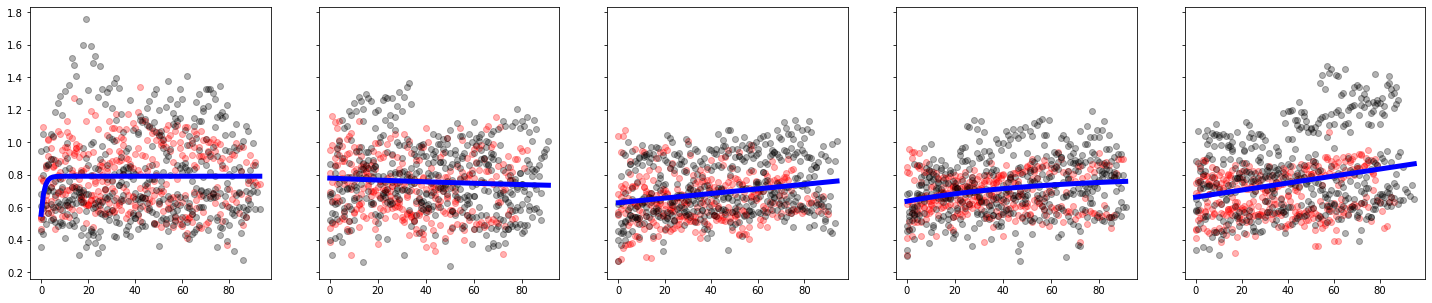

In [5]:
armspeed_results_familiar = stx.behavior.run_model_comparisons.run_model_comparisons_familiar(ko_sessions,ctrl_sessions, 'arm_speed_norm')
with open(os.path.join(figdir_local,'armspeed_results_familiar.pkl'),'wb') as file:
    dill.dump(armspeed_results_familiar,file)
    
fig,ax = stx.behavior.run_model_comparisons.plot_famnov_results(ko_sessions, ctrl_sessions, armspeed_results_familiar,'arm_speed_norm')
fig.savefig(os.path.join(figdir_local,'armspeed_results_familiar.png'))
fig.savefig(os.path.join(figdir_local,'armspeed_results_familiar.pdf'))

In [ ]:
lick_varpos_results_novel = stx.behavior.run_model_comparisons.run_model_comparisons_novel(ko_sessions,ctrl_sessions, 'lick_varpos')
with open(os.path.join(figdir_local,'lick_varpos_results_novel.pkl'),'wb') as file:
    dill.dump(lick_varpos_results_novel,file)

log likelihood [-132.32926109 -131.60366038 -132.82680125 -131.55854777 -131.78427139
 -131.27487917 -131.19123439 -131.83608277]
perm 0


/home/mplitt/repos/STX3KO_analyses/STX3KO_analyses/behavior/models.py:134: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-1 * (b0 * x[1, :] + b1 * (1 - x[1, :])) * x[0, :]) + c0 * x[1, :] + c1 * (1 - x[1, :])


perm 50


/home/mplitt/repos/STX3KO_analyses/STX3KO_analyses/behavior/models.py:134: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-1 * (b0 * x[1, :] + b1 * (1 - x[1, :])) * x[0, :]) + c0 * x[1, :] + c1 * (1 - x[1, :])


In [ ]:
fig,ax = stx.behavior.run_model_comparisons.plot_famnov_results(ko_sessions, ctrl_sessions,lick_varpos_results_novel,'lick_varpos')
fig.savefig(os.path.join(figdir_local,'lick_varpos_results_novel.png'))
fig.savefig(os.path.join(figdir_local,'lick_varpos_results_novel.pdf'))

In [ ]:
lick_acc_results_novel = stx.behavior.run_model_comparisons.run_model_comparisons_novel(ko_sessions,ctrl_sessions, 'lick_acc')
with open(os.path.join(figdir_local,'lick_acc_results_novel.pkl'),'wb') as file:
    dill.dump(lick_acc_results_novel,file)
    
fig,ax = stx.behavior.run_model_comparisons.plot_famnov_results(ko_sessions, ctrl_sessions,lick_acc_results_novel,'lick_acc')
fig.savefig(os.path.join(figdir_local,'lick_acc_results_novel.png'))
fig.savefig(os.path.join(figdir_local,'lick_acc_results_novel.pdf'))

In [ ]:
armspeed_results_novel = stx.behavior.run_model_comparisons.run_model_comparisons_familiar(ko_sessions,ctrl_sessions, 'arm_speed_norm')
with open(os.path.join(figdir_local,'armspeed_results_novel.pkl'),'wb') as file:
    dill.dump(armspeed_results_novel,file)
    
fig,ax = stx.behavior.run_model_comparisons.plot_famnov_results(ko_sessions, ctrl_sessions, armspeed_results_familiar,'arm_speed_norm')
fig.savefig(os.path.join(figdir_local,'armspeed_results_novel.png'))
fig.savefig(os.path.join(figdir_local,'armspeed_results_novel.pdf'))

In [ ]:
# plot for arm speed and lick acc

In [ ]:
[early_rz_results, late_rz_results] =  stx.behavior.run_model_comparisons.run_model_comparisons_rev_lr(ko_sessions, ctrl_sessions)
with open(os.path.join(figdir_local,'lr_extinction_results.pkl'),'wb') as file:
    dill.dump({'early_rz_results':early_rz_results, 'late_rz_results':late_rz_results},file)

In [ ]:
fig,ax = stx.behavior.run_model_comparisons.plot_reversal_lrs(ko_sessions, ctrl_sessions, early_rz_results, late_rz_results)
fig.savefig(os.path.join(figdir_local,'lr_extinction.png'))
fig.savefig(os.path.join(figdir_local,'lr_extinction.pdf'))

In [ ]:

# plot number of omissions

# plot average lickrate for each mouse for different trial types

# plot probe trial lickrate